<a href="https://colab.research.google.com/github/havihaviplants/Machine-learning/blob/main/Optimization_Technique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# 자신의 Google Drive 마운트하는 코드를 추가하자!

mnist = np.load('/content/drive/MyDrive/MY Drive/mnist.npz')

x_train = (mnist['x_train'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_train = mnist['y_train']
x_test = (mnist['x_test'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_test = mnist['y_test']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Train Data Set

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Test Data Set

test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# GPU 사용 여부 확인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class MLP(nn.Module):
 def __init__(self):
  super().__init__()
  self.fc1 = nn.Linear(28*28, 512, bias=False)
  self.fc2 = nn.Linear(512, 512, bias=False)
  self.fc3 = nn.Linear(512, 10, bias=False)

  self.bn1 = nn.BatchNorm1d(512)
  self.bn2 = nn.BatchNorm1d(512)

  self.dropout1 = nn.Dropout(0.3)
  self.dropout2 = nn.Dropout(0.3)

 def forward(self, x):
  x = F.relu(self.bn1(self.fc1(x))) # layer 1
  x = self.dropout1(x)
  x = F.relu(self.bn2(self.fc2(x))) # layer 2
  x = self.dropout2(x)
  x = self.fc3(x) # layer 3

  return x


In [ ]:
from torch.optim import SGD, Adagrad, RMSprop, Adam
model = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Optimization 방법을 변경해보면서 학습속도를 비교해보자!

opti = SGD(model.parameters(), lr=1e-3) # Basic Stochastic Gradient Descent
opti = SGD(model.parameters(), lr=1e-3, momentum=0.9) # Momentum
opti = Adagrad(model.parameters(), lr=1e-3) # Adagrad
opti = RMSprop(model.parameters(), lr=1e-3, alpha=0.99) # RMSprop
opti = Adam(model.parameters(), lr=1e-3) # Adam

In [ ]:
def train(model, dataloader, criterion, data_len, opti):
 correct = 0

 model.train()
 for data, target in dataloader:
  data = data.view(-1, 28 * 28).to(device)
  target = target.to(device)

 output = model(data)
 loss = criterion(output, target)

 opti.zero_grad()
 loss.backward()
 opti.step()

 pred = output.max(1, keepdim=True)[1]
 correct += pred.eq(target.view_as(pred)).sum().item()

 acc = 100. * correct / data_len
 return acc

In [ ]:
def evaluate(model, dataloader, criterion, data_len):
 correct = 0

 model.eval()
 for data, target in dataloader:
  data = data.view(-1, 28 * 28).to(device)
  target = target.to(device)

  output = model(data)
  loss = criterion(output, target)

  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(target.view_as(pred)).sum().item()

 acc = 100. * correct / data_len
 return acc


In [ ]:
def predict(model, dataloader, criterion):
 output_list = []

 model.eval()

 for data, target in dataloader:
  data = data.view(-1, 28 * 28).to(device)
  target = target.to(device)

  output = model(data)
  output_list += output.tolist()

 return np.array(output_list)


In [ ]:
epoch = 7

for i in range(epoch):
 train_acc = train(model, train_dl, criterion, len(train_dl.dataset), opti)
 val_acc = evaluate(model, test_dl, criterion, len(test_dl.dataset))
 print(i, train_acc, val_acc)

0 0.006666666666666667 62.71
1 0.006666666666666667 63.28
2 0.005 63.74
3 0.008333333333333333 63.81
4 0.008333333333333333 64.36
5 0.0033333333333333335 65.12
6 0.006666666666666667 65.93


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, CyclicLR

opti = Adam(model.parameters(), lr=1e-2)
# 여러가지 Scheduler를 변경하면서 학습추이를 비교해보자!

scheduler = StepLR(opti, step_size=30, gamma=0.65)
scheduler = ExponentialLR(opti, gamma=0.98)
scheduler = CosineAnnealingLR(opti, T_max=100, eta_min=1e-3)
scheduler = CyclicLR (opti, base_lr=1e-2, max_lr=1e-1, step_size_up=50,step_size_down=100, mode='triangular', cycle_momentum=False)

lrs = []

for i in range(1000):
 lrs.append(scheduler.get_last_lr())

 opti.step()
 scheduler.step()
lrs = np.array(lrs)


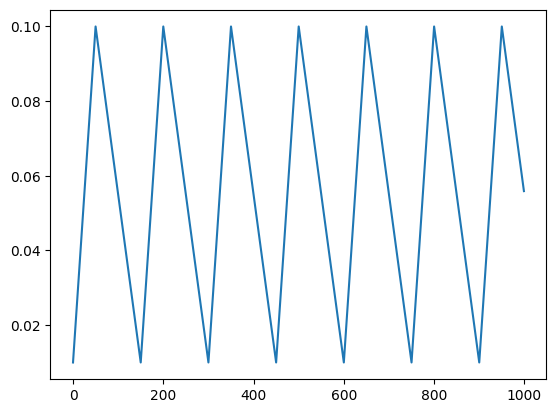

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lrs)
plt.show()


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
k_num = 4
kfold = KFold(n_splits=k_num, shuffle=True)


In [ ]:
epoch = 10
models = [] # 여러 모델들을 저장할 리스트 생성
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
 train_subsampler = SubsetRandomSampler(train_ids)
 val_subsampler = SubsetRandomSampler(val_ids)

 train_dl = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
 val_dl = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)

 model = MLP().to(device)
 opti = Adam(model.parameters(), lr=1e-3)

 for i in range(epoch):
  train_acc = train(model, train_dl, criterion, len(train_subsampler), opti)
 val_acc = evaluate(model, val_dl, criterion, len(val_subsampler))
 print(fold, i, train_acc, val_acc)
 print()

 models.append(model)

0 9 0.006666666666666667 55.733333333333334

1 9 0.008888888888888889 56.94

2 9 0.013333333333333334 61.44

3 9 0.006666666666666667 44.95333333333333



In [ ]:
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)
outputs = []
for model in models:
 test_acc = evaluate(model, test_dl, criterion, len(test_dataset))
 print(test_acc) # 각각의 모델들의 결과를 출력

 output = predict(model, test_dl, criterion)
 outputs.append(output)

# 각 모델들의 결과를 취합해서 하나의 결과로 도출함
outputs = np.sum(np.array(outputs), axis=0)
y_pred = np.argmax(outputs, axis=-1)


57.39
57.31
61.8
45.63


In [ ]:
from sklearn.metrics import accuracy_score
# y_true 데이터만 불러옴 (정확도 측정을 위해서...)
y_true = []
for _, target in test_dl:
 y_true += target.tolist()

y_true = np.array(y_true).reshape(-1,)
print(accuracy_score(y_true, y_pred))

0.6492
